# Multi-dimensional convolution timing benchmarks

### Author: M.Ravasi

This notebook loads the results of different timing benchmarks and visualizes them.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pandas as pd
from datetime import date, datetime

In [2]:
#benchdir = 'Benchmarks/Backup/'
#benchdir = 'Benchmarks/V1/'
benchdir = 'Benchmarks/'

In [3]:
#seldate = str(datetime(2019, 12, 15))[:10] # str(date.today())

Load all benchmarking results

In [4]:
df_forw = pd.read_csv(benchdir+'benchmark_forw.csv')
df_forw = df_forw[df_forw['ffirst']==True]
# df_forw = df_forw[df_forw['time']==seldate]
df_forw = df_forw[df_forw['corechunks']==False]
df_forw.reset_index(inplace=True)

df_adj = pd.read_csv(benchdir+'benchmark_adj.csv')
df_adj = df_adj[df_adj['ffirst']==True]
# df_adj = df_adj[df_adj['time']==seldate]
df_adj = df_adj[df_adj['corechunks']==False]
df_adj.reset_index(inplace=True)

df_forwmulti = pd.read_csv(benchdir+'benchmark_forwmulti.csv')
df_forwmulti = df_forwmulti[df_forwmulti['ffirst']==True]
#df_forwmulti = df_forwmulti[df_forwmulti['time']==seldate]
df_forwmulti.reset_index(inplace=True)

df_adjmulti = pd.read_csv(benchdir+'benchmark_adjmulti.csv')
df_adjmulti = df_adjmulti[df_adjmulti['ffirst']==True]
#df_adjmulti = df_adjmulti[df_adjmulti['time']==seldate]
df_adjmulti.reset_index(inplace=True)

df_forw_PBS = pd.read_csv(benchdir+'benchmark_forw_PBS.csv')
df_forw_PBS = df_forw_PBS[df_forw_PBS['ffirst']==True]
df_forw_PBS = df_forw_PBS[df_forw_PBS['corechunks']==False]
df_forw_PBS.reset_index(inplace=True)

df_adj_PBS = pd.read_csv(benchdir+'benchmark_adj_PBS.csv')
df_adj_PBS = df_adj_PBS[df_adj_PBS['ffirst']==True]
df_adj_PBS = df_adj_PBS[df_adj_PBS['corechunks']==False]
df_adj_PBS.reset_index(inplace=True)

df_forw_K8S = pd.read_csv(benchdir+'benchmark_forw_K8S.csv')
df_forw_K8S = df_forw_K8S[df_forw_K8S['ffirst']==True]
df_forw_K8S.reset_index(inplace=True)

df_adj_K8S = pd.read_csv(benchdir+'benchmark_adj_K8S.csv')
df_adj_K8S = df_adj_K8S[df_adj_K8S['ffirst']==True]
df_adj_K8S.reset_index(inplace=True)

Remove subsampling of 8 from main benchmark

In [5]:
df_forwmulti = df_forwmulti[df_forwmulti['subsampling'] == 2].reset_index(drop=True)
df_adjmulti = df_adjmulti[df_adjmulti['subsampling'] == 2].reset_index(drop=True)

Choose subsampling for multi

In [6]:
#df_forw = df_forw[df_forw['subsampling'] < 8].reset_index(drop=True)
#df_adj = df_adj[df_adj['subsampling'] < 8].reset_index(drop=True)

In [7]:
# Define ideal times for multi
mintime, imintime = df_forwmulti['meantime'].min(), df_forwmulti['meantime'].argmin()
nworkers_mintime, subsampling_mintime = df_forwmulti.iloc[imintime]['nworkers'], df_forwmulti.iloc[imintime]['subsampling']
df_forwmulti['idealtime'] = df_forwmulti['nvs'] * (nworkers_mintime * subsampling_mintime**2) / \
    (df_forwmulti['nworkers'] * df_forwmulti['subsampling']**2)
df_forwmulti['idealtime'] *= mintime

#maxtime, imaxtime = df_forw['meantime'].max(), df_forw['meantime'].argmax()
#nworkers_maxtime, subsampling_maxtime = df_forw.iloc[imaxtime]['nworkers'], df_forw.iloc[imaxtime]['subsampling']
#df_forw['idealtime'] = (nworkers_maxtime * subsampling_maxtime**2)/(df['nworkers'] * df_forw['subsampling']**2)
#df_forw['idealtime'] *= maxtime

In [8]:
df_forw.sort_values(['subsampling', 'nworkers'])

,index,corechunks,ffirst,meantime,nchunks,ncores,nrepeat,ntime,nworkers,ram,rebalance,stdtime,subsampling,time
18,23,False,True,12.402940,"[17, 9801, 9801]",192,2,2,16,126.0 GB,True,1.354794,1,2019-12-30
15,20,False,True,10.553954,"[14, 9801, 9801]",240,2,2,20,126.0 GB,True,0.669720,1,2019-12-30
20,25,False,True,8.130771,"[11, 9801, 9801]",312,2,2,26,126.0 GB,True,1.523820,1,2019-12-30
23,28,False,True,5.737214,"[9, 9801, 9801]",360,2,2,30,126.0 GB,True,0.194627,1,2019-12-30
13,18,False,True,9.262132,"((75, 75, 75, 75), (4901,), (4901,))",48,3,3,4,126.0 GB,True,0.580914,2,2019-12-28
2,5,False,True,4.869072,"[42, 4901, 4901]",96,3,3,8,126.0 GB,True,0.051573,2,2019-12-28
21,26,False,True,3.255738,"[23, 4901, 4901]",144,3,3,12,126.0 GB,True,0.028025,2,2019-12-30
22,27,False,True,2.916336,"[20, 4901, 4901]",168,3,3,14,126.0 GB,True,0.018765,2,2019-12-30
5,8,False,True,2.730931,"[20, 4901, 4901]",192,3,3,16,126.0 GB,True,0.050135,2,2019-12-28
8,13,False,True,2.588131,"[17, 4901, 4901]",192,3,3,16,126.0 GB,True,0.024235,2,2019-12-28


In [9]:
df_adj.sort_values(['subsampling', 'nworkers'])

,index,corechunks,ffirst,meantime,nchunks,ncores,nrepeat,ntime,nworkers,ram,rebalance,stdtime,subsampling,time
18,23,False,True,10.292552,"[17, 9801, 9801]",192,2,2,16,126.0 GB,True,0.505592,1,2019-12-30
15,20,False,True,9.306651,"[14, 9801, 9801]",240,2,2,20,126.0 GB,True,0.187196,1,2019-12-30
20,25,False,True,6.963993,"[11, 9801, 9801]",312,2,2,26,126.0 GB,True,0.162047,1,2019-12-30
23,28,False,True,5.707208,"[9, 9801, 9801]",360,2,2,30,126.0 GB,True,0.155860,1,2019-12-30
13,18,False,True,9.571329,"((75, 75, 75, 75), (4901,), (4901,))",48,3,3,4,126.0 GB,True,0.293331,2,2019-12-28
2,5,False,True,5.042884,"[42, 4901, 4901]",96,3,3,8,126.0 GB,True,0.081016,2,2019-12-28
21,26,False,True,3.348006,"[23, 4901, 4901]",144,3,3,12,126.0 GB,True,0.045268,2,2019-12-30
22,27,False,True,3.043729,"[20, 4901, 4901]",168,3,3,14,126.0 GB,True,0.040727,2,2019-12-30
5,8,False,True,2.775169,"[20, 4901, 4901]",192,3,3,16,126.0 GB,True,0.015848,2,2019-12-28
8,13,False,True,2.684190,"[17, 4901, 4901]",192,3,3,16,126.0 GB,True,0.039048,2,2019-12-28


In [10]:
df_forwmulti.sort_values(['nworkers', 'nvs',])

,index,nworkers,ncores,ram,subsampling,ffirst,meantime,stdtime,nchunks,rebalance,nrepeat,ntime,nvs,time,idealtime
4,4,4,48,126.0 GB,2,True,3.409291,0.046531,"[6, 4901, 4901]",True,2,3,1,2019-12-30,4.478151
5,5,4,48,126.0 GB,2,True,6.728091,0.761403,"[6, 4901, 4901]",True,2,3,5,2019-12-30,22.390757
6,6,4,48,126.0 GB,2,True,8.988670,0.128813,"[6, 4901, 4901]",True,2,3,10,2019-12-30,44.781514
7,7,4,48,126.0 GB,2,True,40.195277,0.972775,"[6, 4901, 4901]",True,2,3,25,2019-12-30,111.953785
0,0,8,96,126.0 GB,2,True,2.239076,0.020495,"[3, 4901, 4901]",True,2,3,1,2019-12-30,2.239076
1,1,8,96,126.0 GB,2,True,4.545739,0.043698,"[3, 4901, 4901]",True,2,3,5,2019-12-30,11.195378
2,2,8,96,126.0 GB,2,True,7.424436,0.270126,"[3, 4901, 4901]",True,2,3,10,2019-12-30,22.390757
3,3,8,96,126.0 GB,2,True,32.201235,0.187561,"[3, 4901, 4901]",True,2,3,25,2019-12-30,55.976892


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


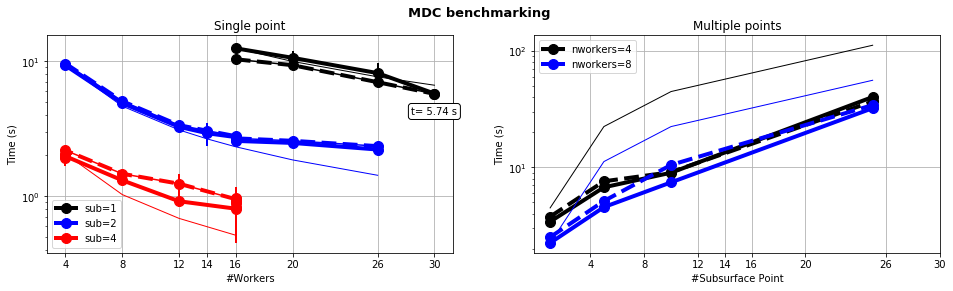

In [11]:
subsampling = [1, 2, 4]
nworkers = [4, 8]
colors = ['k', 'b', 'r', 'g']

fig, (ax, axmulti) = plt.subplots(1, 2, figsize=(16, 4))
fig.suptitle('MDC benchmarking', fontweight='bold', fontsize=13)
for sub, color in zip(subsampling, colors):
    nworkers_forw = df_forw[df_forw['subsampling']==sub]['nworkers'].values
    nworkers_adj = df_adj[df_adj['subsampling']==sub]['nworkers'].values
    
    meantime_forw = df_forw[df_forw['subsampling']==sub]['meantime'].values
    meantime_adj = df_adj[df_adj['subsampling']==sub]['meantime'].values
    
    stdtime_forw = df_forw[df_forw['subsampling']==sub]['stdtime'].values
    stdtime_adj = df_adj[df_adj['subsampling']==sub]['stdtime'].values

    # Define ideal times - t=(t_nworkers_min / n_workers... behaves as 1/x curve)
    maxtime, imaxtime = meantime_forw.max(), meantime_forw.argmax()
    nworkers_maxtime = nworkers_forw[imaxtime]
    idealtime = (maxtime * nworkers_maxtime) / nworkers_forw
    
    index_forw = np.argsort(nworkers_forw)
    index_adj = np.argsort(nworkers_adj)
    
    ax.semilogy(nworkers_forw[index_forw], 
                meantime_forw[index_forw], '.-'+color, lw=4, ms=20, label='sub=%d' %sub)
    ax.errorbar(nworkers_forw[index_forw], meantime_forw[index_forw], 
                yerr=stdtime_forw, color=color, elinewidth=2)
    ax.semilogy(nworkers_adj[index_adj], 
                meantime_adj[index_adj], '.--'+color, lw=4, ms=20)
    ax.errorbar(nworkers_adj[index_adj], meantime_adj[index_adj], 
                yerr=stdtime_adj, color=color, elinewidth=2)
    ax.semilogy(nworkers_forw[index_forw], 
                idealtime[index_forw], color, lw=1)
    if sub == 1:
        ax.text(nworkers_forw[index_forw][-1], 0.7*meantime_forw[index_forw][-1],
                't= %.2f s' % meantime_forw[index_forw][-1], ha='center',
                bbox=dict(boxstyle="round", fc=(1., 1., 1.), ec='k'))
for nworker, color in zip(nworkers, colors):
    nvs_forwmulti = df_forwmulti[df_forwmulti['nworkers']==nworker]['nvs'].values
    nvs_adjmulti = df_adjmulti[df_adjmulti['nworkers']==nworker]['nvs'].values
    meantime_forwmulti = df_forwmulti[df_forwmulti['nworkers']==nworker]['meantime'].values
    meantime_adjmulti = df_adjmulti[df_adjmulti['nworkers']==nworker]['meantime'].values
    idealtime_forwmulti = df_forwmulti[df_forwmulti['nworkers']==nworker]['idealtime'].values

    index_forwmulti = np.argsort(nvs_forwmulti)
    index_adjmulti = np.argsort(nvs_adjmulti)

    axmulti.semilogy(nvs_forwmulti[index_forwmulti], 
                     meantime_forwmulti[index_forwmulti], '.-'+color, lw=4, ms=20, 
                     label='nworkers=%d' %nworker)
    axmulti.semilogy(nvs_adjmulti[index_adjmulti], 
                     meantime_adjmulti[index_adjmulti], '.--'+color, lw=4, ms=20)
    axmulti.semilogy(nvs_forwmulti[index_forwmulti], 
                     idealtime_forwmulti[index_forwmulti], color, lw=1)
ax.set_xticks(df_forw['nworkers'].unique())
ax.legend()
axmulti.set_xticks(df_forw['nworkers'].unique())
axmulti.legend()
ax.set_xlabel('#Workers')
ax.set_ylabel('Time (s)')
axmulti.set_xlabel('#Subsurface Point')
axmulti.set_ylabel('Time (s)')
ax.set_title('Single point')
axmulti.set_title('Multiple points')
ax.grid('on')
axmulti.grid('on')
plt.savefig('Figures/benchmark.eps', bbox_inches='tight')
plt.savefig('Figures/benchmark.png', dpi=300, bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

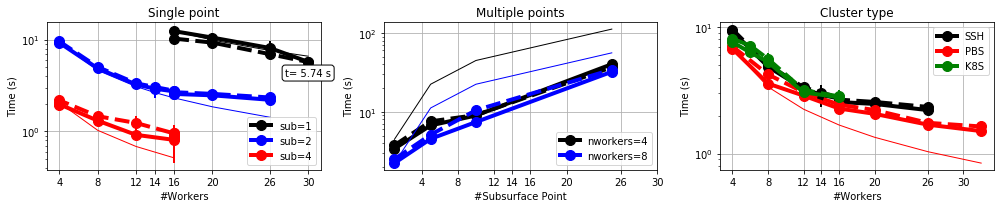

In [12]:
subsampling = [1, 2, 4]
nworkers = [4, 8]
sub_cluster = 2
colors = ['k', 'b', 'r', 'g']

fig, (ax, axmulti, axcluster) = plt.subplots(1, 3, figsize=(14, 3))
#fig.suptitle('MDC benchmarking', y=1.04, fontweight='bold', fontsize=13)
# Subsampling-compute subplot
for sub, color in zip(subsampling, colors):
    nworkers_forw = df_forw[df_forw['subsampling']==sub]['nworkers'].values
    nworkers_adj = df_adj[df_adj['subsampling']==sub]['nworkers'].values
    
    meantime_forw = df_forw[df_forw['subsampling']==sub]['meantime'].values
    meantime_adj = df_adj[df_adj['subsampling']==sub]['meantime'].values
    
    stdtime_forw = df_forw[df_forw['subsampling']==sub]['stdtime'].values
    stdtime_adj = df_adj[df_adj['subsampling']==sub]['stdtime'].values

    # Define ideal times - t=(t_nworkers_min / n_workers... behaves as 1/x curve)
    maxtime, imaxtime = meantime_forw.max(), meantime_forw.argmax()
    nworkers_maxtime = nworkers_forw[imaxtime]
    idealtime = (maxtime * nworkers_maxtime) / nworkers_forw
    
    index_forw = np.argsort(nworkers_forw)
    index_adj = np.argsort(nworkers_adj)
    
    ax.semilogy(nworkers_forw[index_forw], 
                meantime_forw[index_forw], '.-'+color, lw=4, ms=20, label='sub=%d' %sub)
    ax.errorbar(nworkers_forw[index_forw], meantime_forw[index_forw], 
                yerr=stdtime_forw, linewidth=0, ecolor=color, elinewidth=2)
    ax.semilogy(nworkers_adj[index_adj], 
                meantime_adj[index_adj], '.--'+color, lw=4, ms=20)
    ax.errorbar(nworkers_adj[index_adj], meantime_adj[index_adj], 
                yerr=stdtime_adj, linewidth=0, ecolor=color, elinewidth=2)
    ax.semilogy(nworkers_forw[index_forw], 
                idealtime[index_forw], color, lw=1)
    if sub == 1:
        ax.text(nworkers_forw[index_forw][-1], 0.7*meantime_forw[index_forw][-1],
                't= %.2f s' % meantime_forw[index_forw][-1], ha='center',
                bbox=dict(boxstyle="round", fc=(1., 1., 1.), ec='k'))
# Nvs subplot
for nworker, color in zip(nworkers, colors):
    nvs_forwmulti = df_forwmulti[df_forwmulti['nworkers']==nworker]['nvs'].values
    nvs_adjmulti = df_adjmulti[df_adjmulti['nworkers']==nworker]['nvs'].values
    meantime_forwmulti = df_forwmulti[df_forwmulti['nworkers']==nworker]['meantime'].values
    meantime_adjmulti = df_adjmulti[df_adjmulti['nworkers']==nworker]['meantime'].values
    idealtime_forwmulti = df_forwmulti[df_forwmulti['nworkers']==nworker]['idealtime'].values

    index_forwmulti = np.argsort(nvs_forwmulti)
    index_adjmulti = np.argsort(nvs_adjmulti)

    axmulti.semilogy(nvs_forwmulti[index_forwmulti], 
                     meantime_forwmulti[index_forwmulti], '.-'+color, lw=4, ms=20, 
                     label='nworkers=%d' %nworker)
    axmulti.semilogy(nvs_adjmulti[index_adjmulti], 
                     meantime_adjmulti[index_adjmulti], '.--'+color, lw=4, ms=20)
    axmulti.semilogy(nvs_forwmulti[index_forwmulti], 
                     idealtime_forwmulti[index_forwmulti], color, lw=1)
    
# Cluster type subplot
nworkers_forw = df_forw[df_forw['subsampling']==sub_cluster]['nworkers'].values
nworkers_adj = df_adj[df_adj['subsampling']==sub_cluster]['nworkers'].values
meantime_forw = df_forw[df_forw['subsampling']==sub_cluster]['meantime'].values
meantime_adj = df_adj[df_adj['subsampling']==sub_cluster]['meantime'].values
stdtime_forw = df_forw[df_forw['subsampling']==sub_cluster]['stdtime'].values
stdtime_adj = df_adj[df_adj['subsampling']==sub_cluster]['stdtime'].values

nworkers_forw_PBS = df_forw_PBS[df_forw_PBS['subsampling']==sub_cluster]['nworkers'].values
nworkers_adj_PBS = df_adj_PBS[df_adj_PBS['subsampling']==sub_cluster]['nworkers'].values
meantime_forw_PBS = df_forw_PBS[df_forw_PBS['subsampling']==sub_cluster]['meantime'].values
meantime_adj_PBS = df_adj_PBS[df_adj_PBS['subsampling']==sub_cluster]['meantime'].values
stdtime_forw_PBS = df_forw_PBS[df_forw_PBS['subsampling']==sub_cluster]['stdtime'].values
stdtime_adj_PBS = df_adj_PBS[df_adj_PBS['subsampling']==sub_cluster]['stdtime'].values

nworkers_forw_K8S = df_forw_K8S[df_forw_K8S['subsampling']==sub_cluster]['nworkers'].values
nworkers_adj_K8S = df_adj_K8S[df_adj_K8S['subsampling']==sub_cluster]['nworkers'].values
meantime_forw_K8S = df_forw_K8S[df_forw_K8S['subsampling']==sub_cluster]['meantime'].values
meantime_adj_K8S = df_adj_K8S[df_adj_K8S['subsampling']==sub_cluster]['meantime'].values
stdtime_forw_K8S = df_forw_K8S[df_forw_K8S['subsampling']==sub_cluster]['stdtime'].values
stdtime_adj_K8S = df_adj_K8S[df_adj_K8S['subsampling']==sub_cluster]['stdtime'].values

# Define ideal times
maxtime, imaxtime = meantime_forw_PBS.max(), meantime_forw_PBS.argmax()
nworkers_maxtime = nworkers_forw_PBS[imaxtime]
idealtime = (maxtime * nworkers_maxtime) / nworkers_forw_PBS

index_forw = np.argsort(nworkers_forw)
index_adj = np.argsort(nworkers_adj)

index_forw_PBS = np.argsort(nworkers_forw_PBS)
index_adj_PBS = np.argsort(nworkers_adj_PBS)

index_forw_K8S = np.argsort(nworkers_forw_K8S)
index_adj_K8S = np.argsort(nworkers_adj_K8S)

axcluster.semilogy(nworkers_forw[index_forw], 
                   meantime_forw[index_forw], '.-k', lw=4, ms=20, label='SSH')
axcluster.errorbar(nworkers_forw[index_forw], meantime_forw[index_forw], 
                   yerr=stdtime_forw, linewidth=0, ecolor='k', elinewidth=2)
axcluster.semilogy(nworkers_adj[index_adj], 
                   meantime_adj[index_adj], '.--k', lw=4, ms=20)
axcluster.errorbar(nworkers_adj[index_adj], meantime_adj[index_adj], 
                   yerr=stdtime_adj, linewidth=0, ecolor='k', elinewidth=2)

axcluster.semilogy(nworkers_forw_PBS[index_forw_PBS], 
                   meantime_forw_PBS[index_forw_PBS], '.-r', lw=4, ms=20, label='PBS')
axcluster.errorbar(nworkers_forw_PBS[index_forw_PBS], meantime_forw_PBS[index_forw_PBS], 
                   yerr=stdtime_forw_PBS, linewidth=0, ecolor='r', elinewidth=2)
axcluster.semilogy(nworkers_adj_PBS[index_adj_PBS], 
                   meantime_adj_PBS[index_adj_PBS], '.--r', lw=4, ms=20)
axcluster.errorbar(nworkers_adj_PBS[index_adj_PBS], meantime_adj_PBS[index_adj_PBS], 
                   yerr=stdtime_adj_PBS, linewidth=0, ecolor='r', elinewidth=2)

axcluster.semilogy(nworkers_forw_K8S[index_forw_K8S], 
                   meantime_forw_K8S[index_forw_K8S], '.-g', lw=4, ms=20, label='K8S')
axcluster.errorbar(nworkers_forw_K8S[index_forw_K8S], meantime_forw_K8S[index_forw_K8S], 
                   yerr=stdtime_forw_K8S, linewidth=0, ecolor='g', elinewidth=2)
axcluster.semilogy(nworkers_adj_K8S[index_adj_K8S], 
                   meantime_adj_K8S[index_adj_K8S], '.--g', lw=4, ms=20)
axcluster.errorbar(nworkers_adj_K8S[index_adj_K8S], meantime_adj_K8S[index_adj_K8S], 
                   yerr=stdtime_adj_K8S, linewidth=0, ecolor='g', elinewidth=2)
axcluster.semilogy(nworkers_forw_PBS[index_forw_PBS],
                   idealtime[index_forw_PBS], 'r', lw=1)
ax.set_xticks(df_forw['nworkers'].unique())
ax.legend()
ax.set_xlabel('#Workers')
ax.set_ylabel('Time (s)')
ax.set_title('Single point')
axmulti.set_xticks(df_forw['nworkers'].unique())
axmulti.legend()
axmulti.set_xlabel('#Subsurface Point')
axmulti.set_ylabel('Time (s)')
axmulti.set_title('Multiple points')
axcluster.set_xticks(df_forw['nworkers'].unique())
axcluster.legend()
axcluster.set_xlabel('#Workers')
axcluster.set_ylabel('Time (s)')
axcluster.set_title('Cluster type')
ax.grid('on')
axmulti.grid('on')
axcluster.grid('on')
plt.tight_layout()
plt.savefig('Figures/benchmark.eps', bbox_inches='tight')
plt.savefig('Figures/benchmark.png', dpi=300, bbox_inches='tight')